# Explore schemas and query tables

In [1]:
import datajoint as dj

In [2]:
dj.list_schemas()

[2022-09-20 15:57:48,832][INFO]: Connecting dimitri@db.ust-data-sci.net:3306
[2022-09-20 15:57:49,638][INFO]: Connected dimitri@db.ust-data-sci.net:3306


['shared_sales',
 'dimitri_enroll',
 'dimitri_language2',
 'dimitri_university',
 'dimitri_language',
 'dimitri_test',
 'shared_sakila']

In [3]:
schema = dj.Schema('shared_sales')
#schema = dj.Schema('shared_sakila')


In [4]:
# create classes for working with tables
schema.spawn_missing_classes()

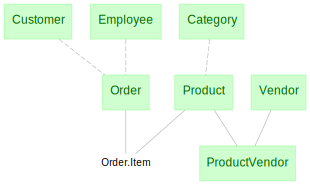

In [5]:
dj.Diagram(schema)

In [6]:
# query a table through its class
Employee()

employee_id,employee_first_name,employee_last_name,employee_street_address,employee_city,employee_state,employee_zipcode,employee_area_code,employee_phone,employee_birthdate
701,Ann,Patterson,16 Maple Lane,Auburn,WA,98002,253,555-2591,1958-03-18
702,Mary,Thompson,122 Spring River Drive,Duvall,WA,98019,425,555-2516,1990-06-21
703,Matt,Berg,908 W. Capital Way,Tacoma,WA,98413,253,555-2581,1964-11-02
704,Carol,Viescas,722 Moss Bay Blvd.,Kirkland,WA,98033,425,555-2576,1987-12-23
705,Kirk,DeGrasse,455 West Palm Ave,San Antonio,TX,78284,210,5552311,1985-10-05
706,David,Viescas,16679 NE 42nd Court,Redmond,WA,98052,425,555-2661,1968-01-01
707,Kathryn,Patterson,554 E. Wilshire Apt. 2A,Seattle,WA,98105,206,555-2697,1982-12-12
708,Susan,McLain,511 Lenora Ave,Bellevue,WA,98006,425,555-2301,1967-10-15


## Enable SQL Magic

In [ ]:
import json
with open('cred.json') as f:
    creds = json.load(f)

connection_string = "mysql://{user}:{password}@{host}".format(**creds)

import pymysql 
pymysql.install_as_MySQLdb()

In [ ]:
%load_ext sql
%config SqlMagic.autocommit=True
%sql $connection_string

In [ ]:
%%sql

SHOW SCHEMAS

In [ ]:
%%sql

USE shared_sales

In [ ]:
%%sql

SHOW TABLES

In [ ]:
%%sql

SHOW CREATE TABLE category;

In [ ]:
%%sql

-- show all customers from Texas 

SELECT *
FROM customer
WHERE customer_state = "TX"


In [ ]:
%%sql

-- show the names and addresses of all Texas customers sorted by last name 

SELECT CONCAT(customer_first_name, ' ', customer_last_name) AS full_name, 
    customer_street_address AS address
  FROM customer
  WHERE customer_state = "TX"
  ORDER BY customer_last_name;

```sql
-- show the names and addresses of all Texas customers sorted by last name 

SELECT CONCAT(customer_first_name, ' ', customer_last_name) AS full_name, 
    customer_street_address AS address
  FROM customer
  WHERE customer_state = "TX"
  ORDER BY customer_last_name;
```

In [ ]:
%%sql

-- show the name of the most expensive product 
-- A bad query.

SELECT product_name, max(retail_price) as max_price
FROM product

In [ ]:
%%sql

-- show the name of the most expensive product 

SELECT product_name, retail_price
FROM product
ORDER BY retail_price DESC
LIMIT 1

In [ ]:
%%sql

-- show all products above 10 in quantity and discount them by 10%

SELECT product_number, product_name, retail_price * 0.9 as retail_price
FROM product
WHERE quantity_on_hand > 10


In [ ]:
%%sql

-- show all orders

SELECT * FROM `order`;

In [ ]:
%%sql
SHOW CREATE TABLE `order`

## Same queries in DataJoint

In [ ]:
# show all customers from Texas 
Customer() & 'customer_state = "TX"'

In [ ]:
Customer() & {'customer_state': "TX"}

In [ ]:
# show the names and addresses of all Texas customers sorted by last name 

texas_customers = Customer() &  {'customer_state': "TX"}

q = texas_customers.proj('customer_first_name', 'customer_last_name')

q.fetch(order_by='customer_last_name', as_dict=True)

In [ ]:
# show the name of the most expensive product 
Product().proj('product_name', 'retail_price').fetch(
    'product_name', limit=1, order_by='retail_price DESC')[0]

In [ ]:
# show all products above 10 in quantity and discount them by 10%
(Product() & 'quantity_on_hand > 10').proj(
    'product_name', retail_price='retail_price * 0.9')

## Queries with subqueries in restriction

In [ ]:
dj.Diagram(schema)

In [ ]:
# Give me all orders for Texas customers

texas_customers = Customer() & {'customer_state': 'TX'}
Order & texas_customers

In [ ]:
%%sql

SELECT customer_id 
FROM customer
WHERE customer_state = "TX"

In [ ]:
%%sql

-- orders placed by Texas customers

SELECT * FROM `order`
WHERE customer_id IN (
    SELECT customer_id 
    FROM customer
    WHERE customer_state = "TX"
)

In [ ]:
Product()

In [ ]:
%%sql 
-- select all orders containing product_number 1

SELECT * FROM `order` WHERE order_number IN (
SELECT order_number FROM `order__item` WHERE product_number = 1)


In [ ]:
Order & (Order.Item & 'product_number=1')

In [ ]:
# Show all customers who have never placed an order

In [ ]:
%%sql
SELECT * FROM customer WHERE customer_id NOT IN 
(SELECT customer_id FROM `order`)

In [ ]:
Customer - Order

In [ ]:
%%sql 
-- products with the word "Bike" in their names
SELECT * FROM product WHERE product_name LIKE "%Bike%"